# 1) Cargamos los datos 📕

In [24]:
import pandas as pd

In [25]:
data = pd.read_csv("data.csv", sep=',') 

In [26]:
data.head(5)

,edad,sexo,alfabeto,sistema_salud,nivel_educativo,ocupacion_jerarquia,ingreso
0,52,0,0,1,6,2,25000
1,43,0,0,1,2,2,23000
2,50,1,0,5,3,2,3800
3,22,1,0,5,4,2,8000
4,44,0,0,5,3,2,18000


# 4) Regresión 🤑

### 4.1) Análisis exploratorio de datos (AED)

Histogramas de las variables:

/tmp/ipykernel_5358/1839998513.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = fig.gca())


array([[<Axes: title={'center': 'edad'}>,
        <Axes: title={'center': 'sexo'}>,
        <Axes: title={'center': 'alfabeto'}>],
       [<Axes: title={'center': 'sistema_salud'}>,
        <Axes: title={'center': 'nivel_educativo'}>,
        <Axes: title={'center': 'ocupacion_jerarquia'}>],
       [<Axes: title={'center': 'ingreso'}>, <Axes: >, <Axes: >]],
      dtype=object)

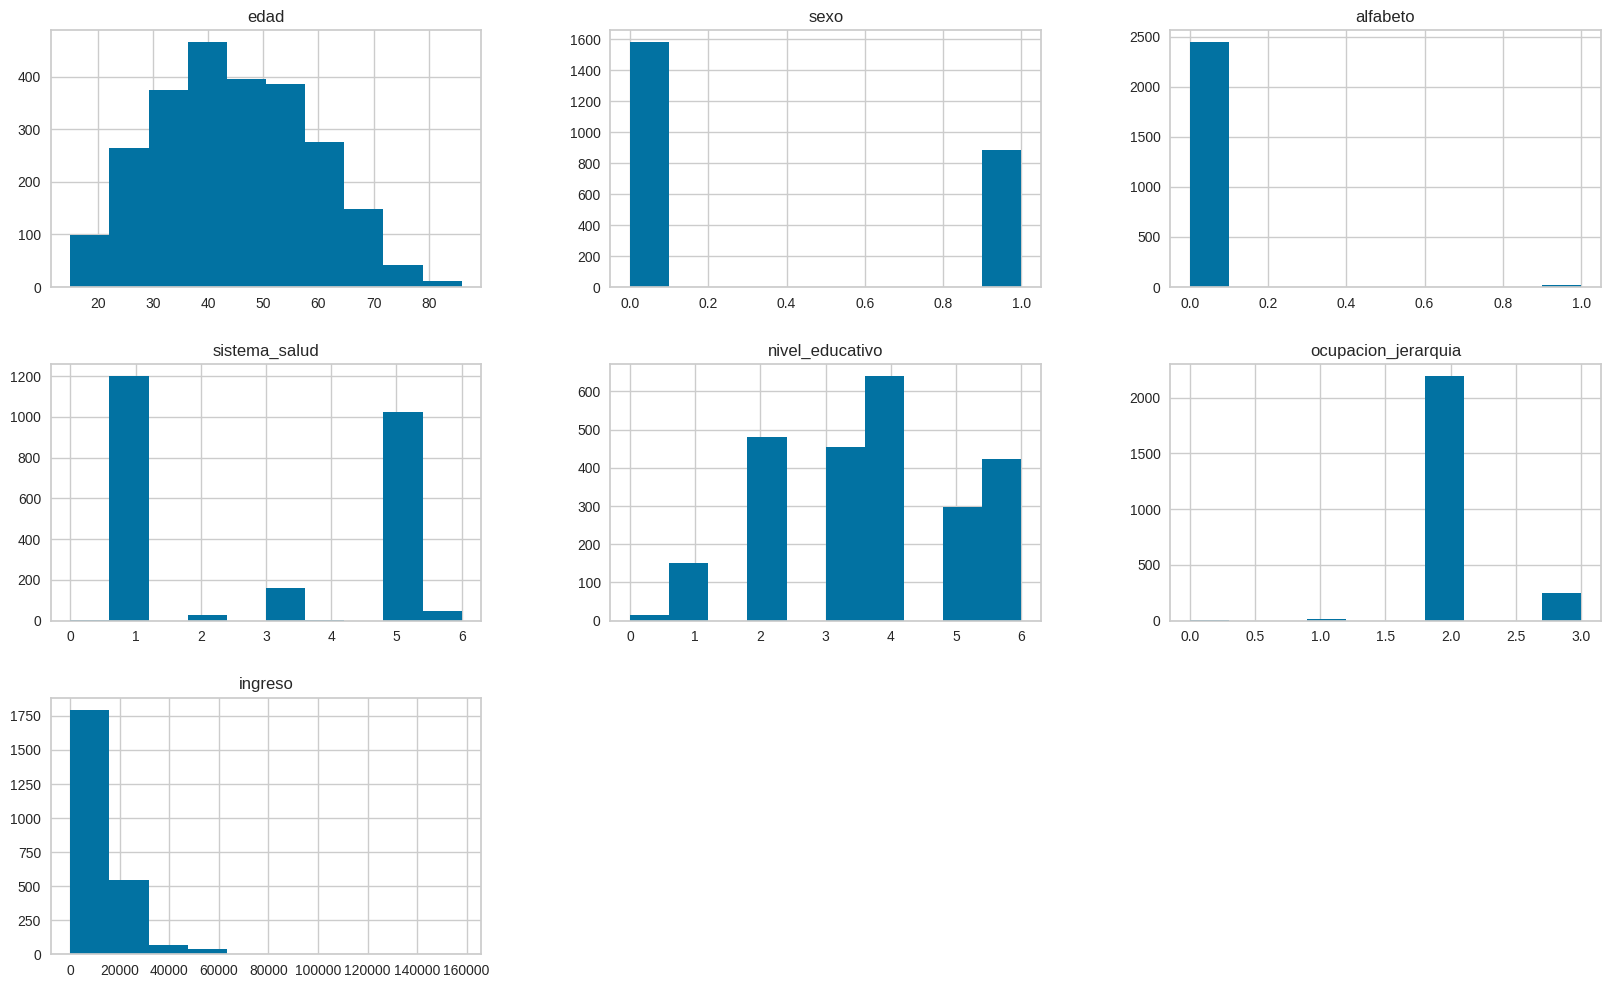

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,12))
data.hist(ax = fig.gca())

### 4.2) Separación TR/TS

In [28]:
x_data_reg = data.drop('ingreso', axis=1)
y_data_reg = data['ingreso']

Obtenemos los valores del dataframe, para evitar el siguiente warning más adelante.
<br>UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names.

In [29]:
x_data_reg = x_data_reg.values
y_data_reg = y_data_reg.values

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data_reg, y_data_reg, test_size=0.3)

### 4.3) Creación del modelo de regresión lineal

In [31]:
from sklearn.linear_model import LinearRegression

# a.Creamos modelo
model = LinearRegression()

# b. fiteamos
model.fit(x_train, y_train)

# c. obtenemos predicciónes para tr y ts
pred_tr=model.predict(x_train)
pred_ts=model.predict(x_test)

In [32]:
pred_tr[0:5]

array([22758.6024218 ,  7537.30992174, 12174.54210397, 15970.90281531,
        4825.2850003 ])

**Nota:** No hay parámetros

### 4.4) Creación del RF con hypertuning (usando grid search)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

model_rf = RandomForestRegressor()

In [34]:
params = {
    'n_estimators' : [10, 20, 500, 5000],
    'max_features': [50, 100],
    #'bootstrap': [False, True],
    #'max_depth': [50, 500],
    #'min_samples_leaf': [3, 50],
    #'min_samples_split': [10, 50],
}

grid_rf = GridSearchCV(estimator = model_rf,
                        param_grid = params,
                        scoring = 'neg_mean_absolute_error',
                        cv = 5, 
                        verbose = 1
                        )

Actualmente hay un conflicto de procesamiento en paralelo con GridSearchCV, por eso no se recomienda el uso de n_paralel.

Esta celda toma algunos minutos (aprox 10 min), mientras tanto espera el resultado con un café o mate 😎

In [35]:
grid_rf.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [50, 100],
                         'n_estimators': [10, 20, 500, 5000]},
             scoring='neg_mean_absolute_error', verbose=1)

In [36]:
grid_rf.best_estimator_

RandomForestRegressor(max_features=100, n_estimators=500)

Predicción de casos nuevos:

In [37]:
grid_rf.predict(x_train)
grid_rf.predict(x_test)

array([ 9132.66190476, 17248.05952381, 16379.7       ,  7864.27619048,
        6796.98333333,  8692.47047619, 13997.9984127 , 50484.83333333,
        8865.03333333,  1151.48      ,  6800.68116883, 12182.78038448,
        7672.7047619 ,  8054.82857143, 14623.36349206, 10738.32799423,
       16379.7       ,  3052.33333333, 10527.85333333, 10753.46666667,
        6429.81809524,  9361.92539683,  8778.95238095, 13105.9952381 ,
       32385.79365079,  5094.26548341,  5901.29365079,  4284.03333333,
        6340.63095238, 13290.37118101, 12182.78038448,  4683.97380952,
       17062.7       ,  7576.48571429,  5081.94166667, 11364.82165945,
       13049.83174603, 15646.        , 21947.        ,  8302.61212121,
        7911.44      , 17372.04564935,  4473.49642857, 12231.3797619 ,
        6012.30454545,  9184.6       ,  5777.35714286,  9602.95      ,
       17524.22922078, 13726.57904762, 10420.12638473, 28486.31428571,
       16200.36666667,  6941.90952381, 12662.13333333, 13586.14603175,
      

### 4.5) Análisis de las métricas de error

**NOTA:** neg_mean_absolute_error más cercano a 0 es mucho mejor.

In [38]:
pd.concat([pd.DataFrame(grid_rf.cv_results_["params"]),
           pd.DataFrame(grid_rf.cv_results_["mean_test_score"], 
                        columns=["neg_mean_absolute_error"])],axis=1).sort_values('neg_mean_absolute_error', ascending=False)

,max_features,n_estimators,neg_mean_absolute_error
6,100,500,-7673.478019
3,50,5000,-7691.105788
7,100,5000,-7695.190074
2,50,500,-7721.316615
5,100,20,-7773.601186
1,50,20,-7808.557915
4,100,10,-7841.424240
0,50,10,-7866.731862


Análisis métrica TR vs TS:

In [39]:
grid_rf.score(x_train, y_train)

-4222.76440329418

In [40]:
grid_rf.score(x_test, y_test)

-7460.350750852219

Links útiles:

- Para investigar más de `gridsearch`: [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).
- Doc oficial [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

### 4.6) Gráfico de la curva del error

**Gráfico de prediction error**

- Linea gris: Lo que nos gustaría que fuera
- Linea negra: El ajuste de regresión, de la regresión misma

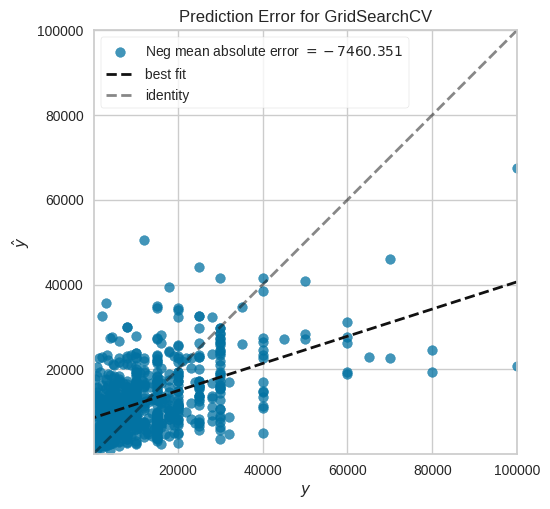

<Axes: title={'center': 'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [41]:
from yellowbrick.regressor import PredictionError

vis_pred_err = PredictionError(grid_rf)

vis_pred_err.fit(x_train, y_train)  # Fiteamos los datos al visualizador
vis_pred_err.score(x_test, y_test)  # Calculamos las métricas para test
vis_pred_err.show()                 # Visualizamos!

In [42]:
print("Training data shape:", x_train.shape)
print("Prediction data shape:", y_test.shape)

Training data shape: (1722, 6)
Prediction data shape: (739,)


# GO BACK TO STUDY REGRESION!
![](https://media.giphy.com/media/EvNfyRC5HMVzi/giphy.gif)

**Gráfico de residuos**

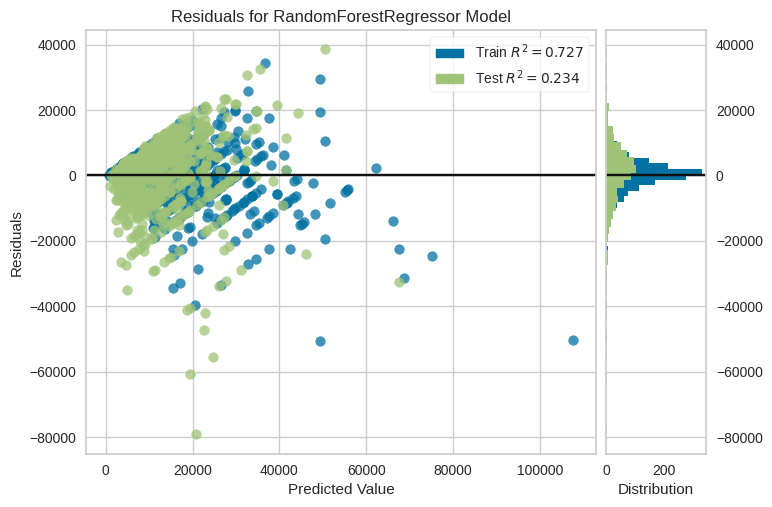

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
from yellowbrick.regressor import ResidualsPlot

# ojo: poner best_estimator_
vis_res = ResidualsPlot(grid_rf.best_estimator_)


# Copy-paste de la doc oficial: 
vis_res.fit(x_train, y_train)  # Fiteamos los datos al visualizador
vis_res.score(x_test, y_test)  # Calculamos las métricas para test
vis_res.show()                 # Visualizamos!

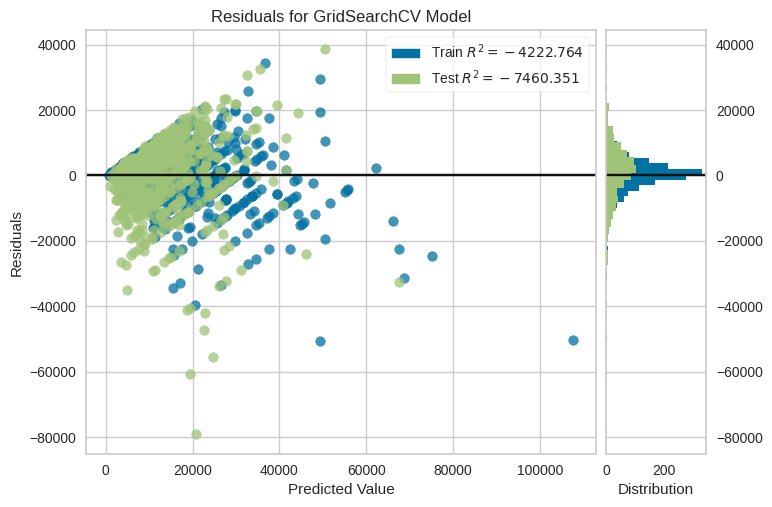

<Axes: title={'center': 'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [44]:
vis_res2 = ResidualsPlot(grid_rf)

# Copy-paste de la doc oficial: https://www.scikit-yb.org/en/latest/quickstart.html
vis_res2.fit(x_train, y_train)  # Fiteamos los datos al visualizador
vis_res2.score(x_test, y_test)  # Calculamos las métricas para test
vis_res2.show()                 # Visualizamos!

Doc oficial: https://www.scikit-yb.org/en/latest/quickstart.html

# 5) Guardar un modelo

Vamos a guardar el modelo de clasificación

In [45]:
import pickle

In [46]:
# Guardar en el disco
filename = 'model1.pkl'
pickle.dump(grid_rf, open(filename, 'wb')) # rf = nuestro modelo

In [47]:
# Lo cargamos para usarlo en otro momento. 
rf_loaded = pickle.load(open(filename, 'rb'))